<a href="https://colab.research.google.com/github/Dogolaa/ArtificialIntelligence/blob/main/Trabalho_Final_Part1_Realmente_Pronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install ucimlrepo

# Atividade 3

Lucas Dogo de Souza Pezzuto - 2020.1.08.026

Matheus Malvão Barbosa - 2020.1.08.025

### Introdução ao Projeto
Este notebook foca na comparação de três técnicas de aprendizado de máquina para classificar casos de câncer de mama com base na base de dados de Wisconsin. As técnicas utilizadas são Regressão Logística, Árvores de Decisão e Random Forest.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

from sklearn.model_selection import ParameterGrid
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Carregamento e Preparação dos Dados
Os dados são carregados e as características necessárias são extraídas. Também realizamos a conversão dos rótulos para formatos binários para facilitar o processamento.


In [ ]:
# URL do arquivo CSV
data_url = 'https://archive.ics.uci.edu/static/public/17/data.csv'

# Carregar o CSV diretamente do URL
df = pd.read_csv(data_url)

# Exibir as primeiras linhas para confirmar o carregamento correto
print(df.head())

         ID  radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    842302    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    842517    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2  84300903    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3  84348301    11.42     20.38       77.58   386.1      0.14250       0.28390   
4  84358402    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  ...  texture3  perimeter3   area3  \
0      0.3001          0.14710     0.2419  ...     17.33      184.60  2019.0   
1      0.0869          0.07017     0.1812  ...     23.41      158.80  1956.0   
2      0.1974          0.12790     0.2069  ...     25.53      152.50  1709.0   
3      0.2414          0.10520     0.2597  ...     26.50       98.87   567.7   
4      0.1980          0.10430     0.1809  ...     16.67      152.20  1575.0   

   smoothness3  compactness3  co

### Separando a Base de Dados

Nesta seção, dividimos a base de dados em conjuntos de treinamento e teste. A separação é crucial para evitar o overfitting e para avaliar o desempenho dos modelos de forma mais objetiva e imparcial em dados não vistos durante o treinamento.

- **Conjunto de Treinamento (70% dos dados):** Usado para treinar os modelos. Contém a maior parte dos dados para permitir que os modelos aprendam de forma eficaz.
- **Conjunto de Teste (30% dos dados):** Usado para testar a precisão dos modelos após o treinamento. Ajuda a entender como o modelo se comportará com novos dados.

A divisão dos dados utiliza um `RANDOM_STATE` para garantir a reprodutibilidade dos resultados, permitindo que a mesma divisão seja reproduzida em futuras execuções.

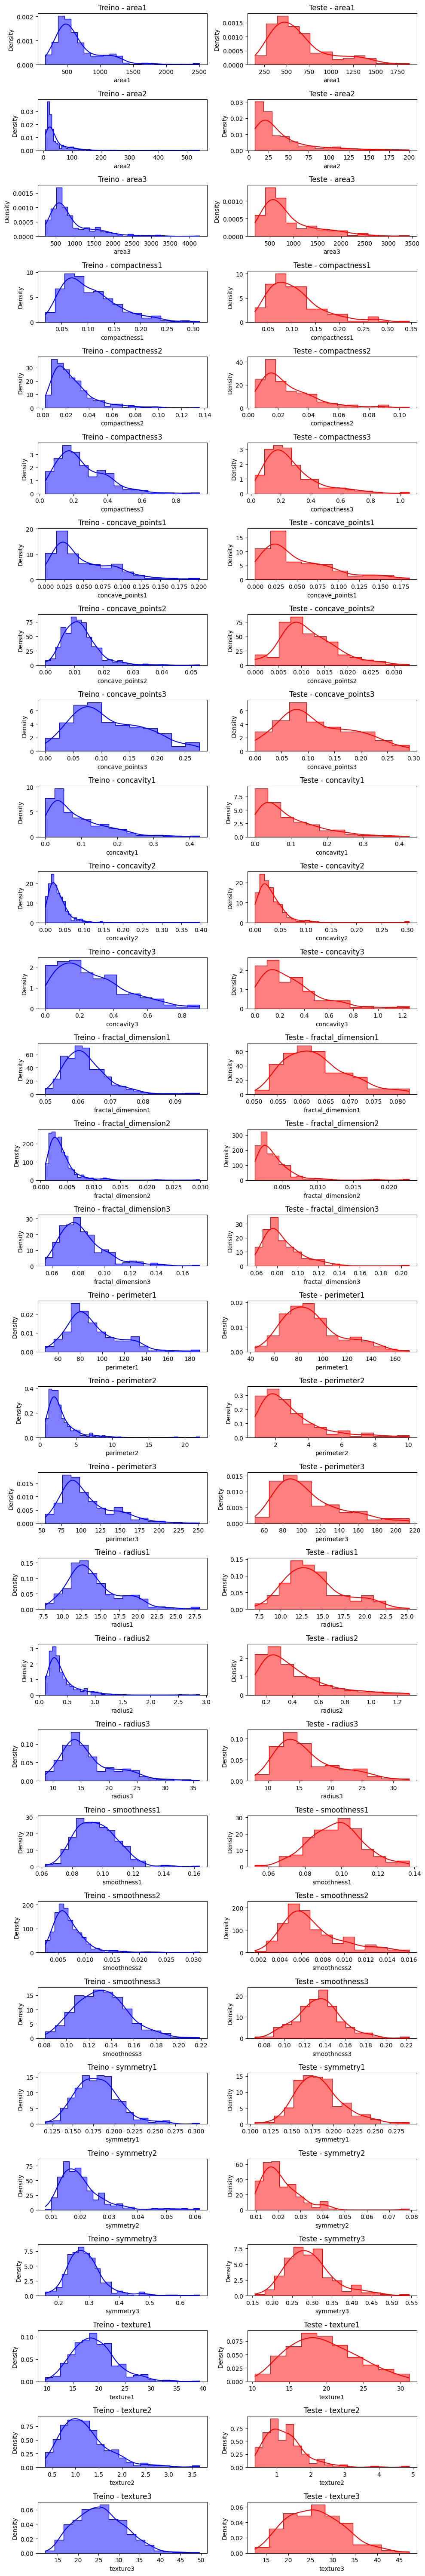

In [ ]:
# Parâmetros de divisão do conjunto de dados
TRAIN_SIZE = 0.7
TEST_SIZE = 0.3
RANDOM_STATE = 42

# Seleção das colunas de características (todas exceto 'ID' e 'Diagnosis')
feature_columns = df.columns.difference(['ID', 'Diagnosis'])
X = df[feature_columns]
y = df['Diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

# Divisão dos dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                    test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Função para plotar a distribuição dos dados
def plot_data_distribution(X_train, X_test, features):
    fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(10, 2 * len(features)))  # Ajustado para uma largura menor
    for i, feature in enumerate(features):
        sns.histplot(X_train[feature], ax=axes[i, 0], color='blue', kde=True, element='step', stat="density", common_norm=False)
        axes[i, 0].set_title(f'Treino - {feature}')
        sns.histplot(X_test[feature], ax=axes[i, 1], color='red', kde=True, element='step', stat="density", common_norm=False)
        axes[i, 1].set_title(f'Teste - {feature}')
    plt.tight_layout()
    plt.show()

# Chamada da função para plotar
plot_data_distribution(X_train, X_test, feature_columns)

### Visualizando a Distribuição do Rótulo 'Diagnosis'

A distribuição do rótulo `'Diagnosis'` nos conjuntos de treino e teste é crucial para entender o equilíbrio entre as classes. Essa visualização nos ajuda a verificar se as classes estão balanceadas ou se existe algum viés que poderia afetar o desempenho dos modelos.

- **Gráfico à esquerda:** Mostra a distribuição dos rótulos no conjunto de treinamento.
- **Gráfico à direita:** Mostra a distribuição dos rótulos no conjunto de teste.

Ambos os gráficos são fundamentais para assegurar que ambos os conjuntos refletem proporções semelhantes de casos, evitando assim que o modelo seja treinado ou testado de maneira tendenciosa.


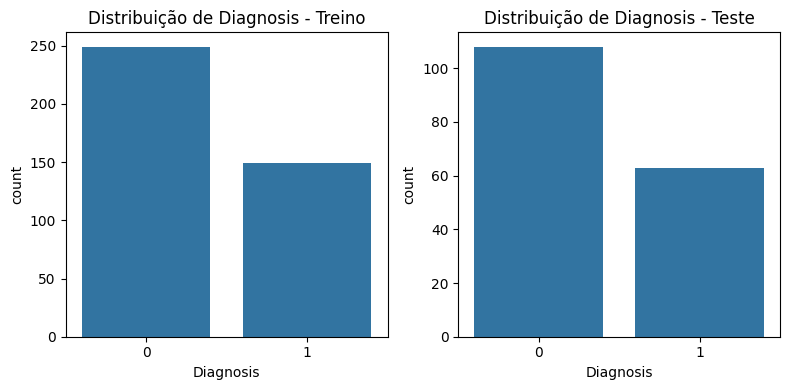

In [ ]:
# Função para visualizar a distribuição do rótulo 'Diagnosis'
def plot_label_distribution(y_train, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # Ajustado para uma largura total menor
    sns.countplot(x=y_train, ax=ax[0])
    ax[0].set_title('Distribuição de Diagnosis - Treino')
    sns.countplot(x=y_test, ax=ax[1])
    ax[1].set_title('Distribuição de Diagnosis - Teste')
    plt.tight_layout()
    plt.show()

# Chamada da função para plotar a distribuição do rótulo
plot_label_distribution(y_train, y_test)

### Função para Treinar e Avaliar Modelos

Nesta seção, definimos uma função que é responsável por treinar e avaliar os modelos de aprendizado de máquina. A função recebe como parâmetros o modelo a ser treinado, os conjuntos de dados de treinamento e teste, e o número de repetições desejadas para a avaliação do modelo. A função realiza os seguintes passos:

1. **Treinamento do Modelo**: O modelo é treinado usando os dados de treinamento fornecidos.
2. **Predição e Avaliação**: Após o treinamento, o modelo é usado para fazer previsões no conjunto de teste. A acurácia dessas previsões é calculada para avaliar o desempenho do modelo.
3. **Validação Cruzada**: Para garantir que a avaliação seja robusta, utilizamos a validação cruzada, que repete o processo de divisão dos dados de treinamento em subconjuntos, treina o modelo em cada subconjunto e valida em outro conjunto. A média dos resultados da validação cruzada é calculada para fornecer uma medida confiável do desempenho do modelo.
4. **Repetições**: O processo de treinamento e avaliação pode ser repetido várias vezes para garantir a consistência dos resultados.

A função retorna os parâmetros utilizados, a acurácia média e a pontuação média da validação cruzada para cada configuração de parâmetros testada. Isso nos permite comparar diferentes configurações e escolher a melhor para nosso modelo.


In [ ]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    return model, accuracy, np.mean(cv_scores)

### Árvore de Decisão
A Árvore de Decisão é um modelo simples e interpretável, usado frequentemente para tarefas de classificação. Aqui, treinamos o modelo com o conjunto de treino e avaliamos sua acurácia e validação cruzada. Adicionalmente, visualizamos a árvore para entender como as decisões estão sendo tomadas.


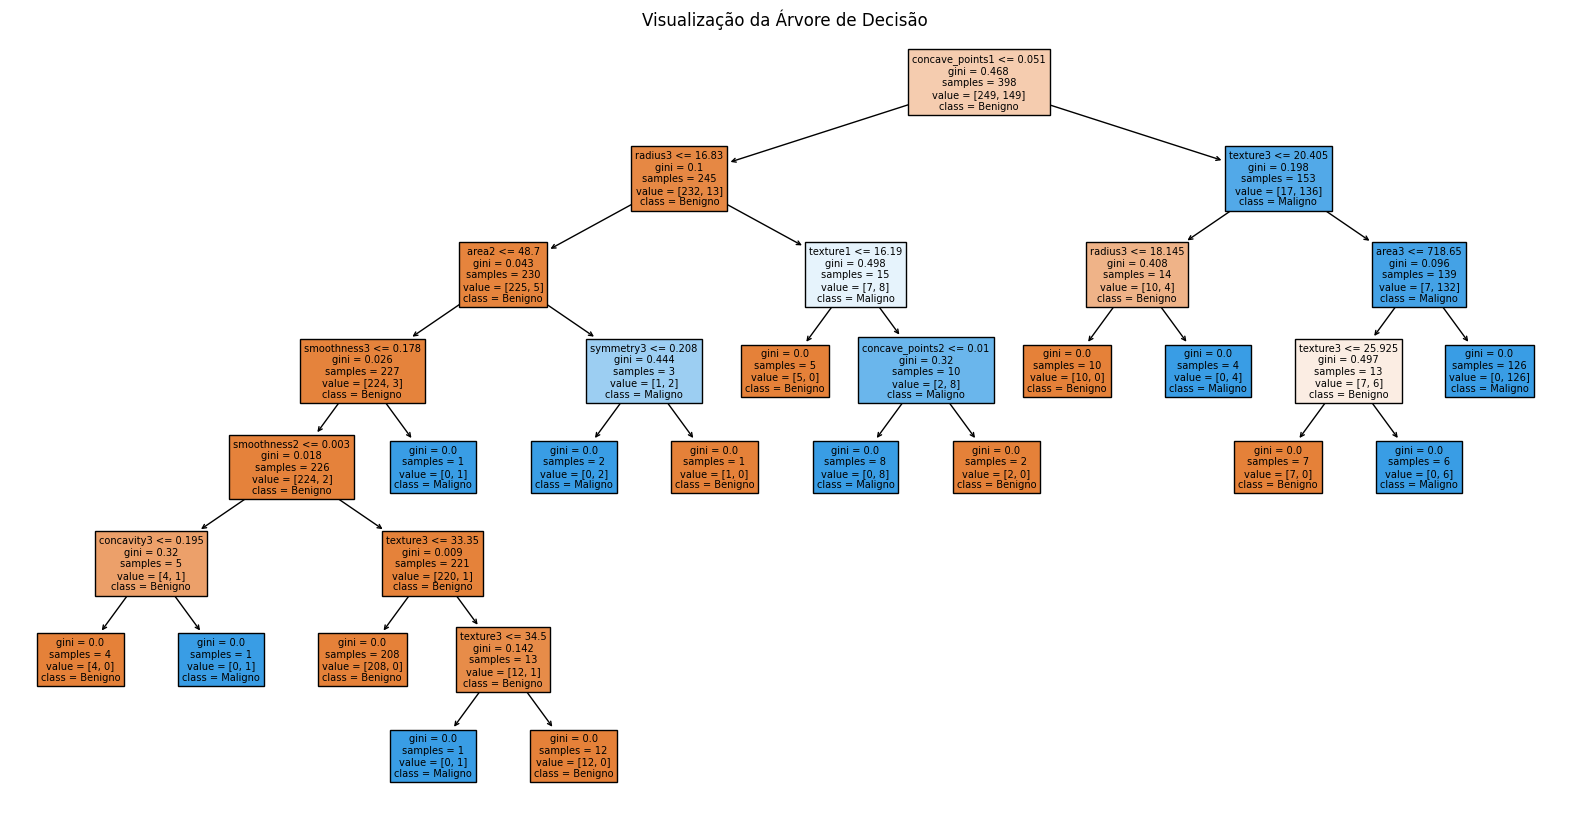

In [ ]:
# Treinando e avaliando o modelo DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model, dt_accuracy, dt_cv_score = train_and_evaluate(decision_tree_model, X_train, X_test, y_train, y_test)

# Visualização da Árvore de Decisão
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=feature_columns, class_names=['Benigno', 'Maligno'])
plt.title('Visualização da Árvore de Decisão')
plt.show()


In [ ]:
# Exibir os resultados
print(f'Decision Tree Test Accuracy: {dt_accuracy}')
print(f'Decision Tree Cross-Validation Accuracy: {dt_cv_score}')

Decision Tree Test Accuracy: 0.9415204678362573
Decision Tree Cross-Validation Accuracy: 0.901923076923077


### Regressão Logística
A Regressão Logística é amplamente utilizada para problemas de classificação binária. Nesta seção, treinamos o modelo de Regressão Logística, calculamos sua acurácia e validação cruzada, e visualizamos os coeficientes para entender a influência de cada característica na decisão.


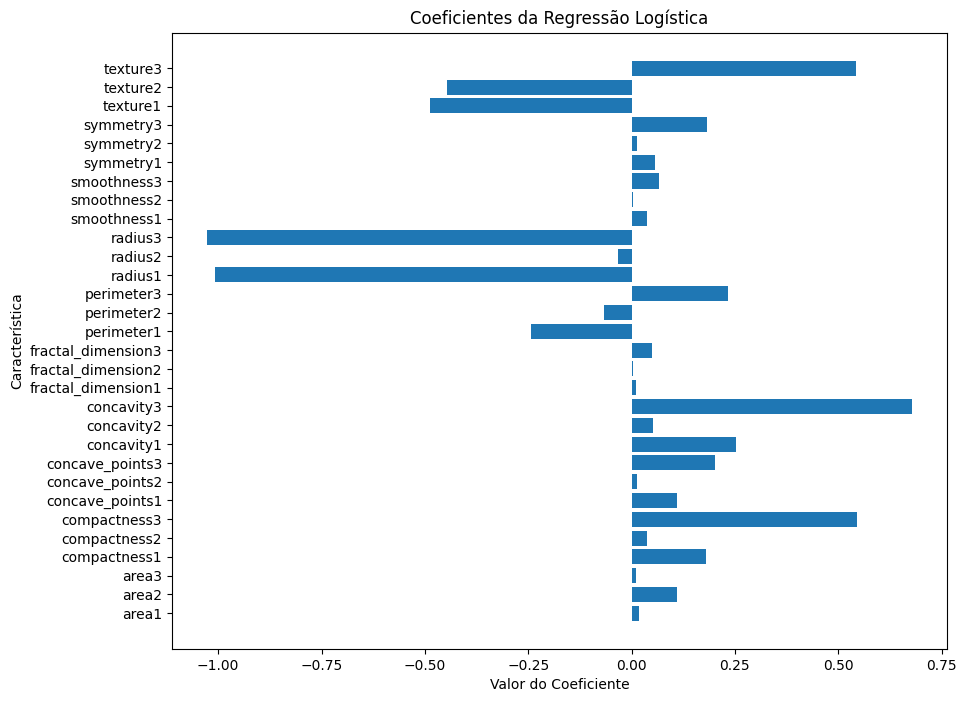

In [ ]:
# Visualização dos coeficientes da Regressão Logística
plt.figure(figsize=(10, 8))
plt.barh(feature_columns, lr_model.coef_[0])
plt.xlabel("Valor do Coeficiente")
plt.ylabel("Característica")
plt.title("Coeficientes da Regressão Logística")
plt.show()

In [ ]:
print(f"Regressão Logística - Acurácia: {lr_accuracy:.2f}, CV Score: {lr_cv_score:.2f}")

Regressão Logística - Acurácia: 0.97, CV Score: 0.93


### Random Forest
Random Forest é um método de ensemble que usa múltiplas árvores de decisão para melhorar a precisão da classificação. Avaliamos sua performance através de acurácia e validação cruzada e visualizamos a importância das características para o modelo.


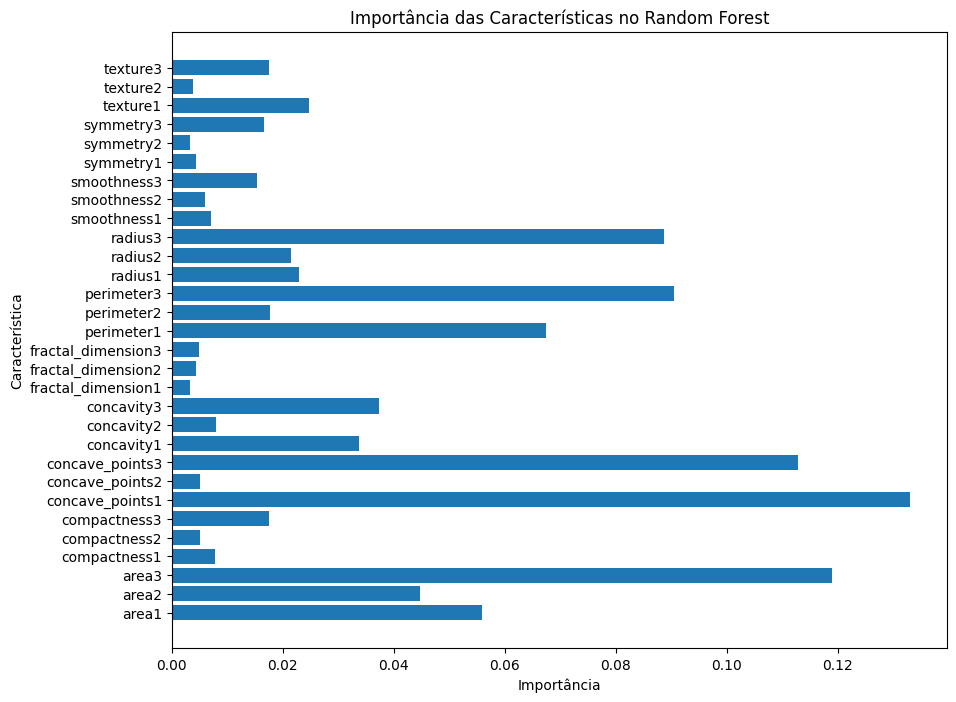

In [ ]:
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model, rf_accuracy, rf_cv_score = train_and_evaluate(random_forest_model, X_train, X_test, y_train, y_test)
plt.figure(figsize=(10, 8))
plt.barh(feature_columns, rf_model.feature_importances_)
plt.xlabel("Importância")
plt.ylabel("Característica")
plt.title("Importância das Características no Random Forest")
plt.show()


In [ ]:
print(f"Random Forest - Acurácia: {rf_accuracy:.2f}, CV Score: {rf_cv_score:.2f}")

Random Forest - Acurácia: 0.97, CV Score: 0.95


### Treinamento e Avaliação dos Modelos
Cada modelo é treinado e avaliado usando uma divisão de treino e teste dos dados, e a validação cruzada é usada para garantir a robustez dos resultados.


In [ ]:
# Definindo os modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)  # Aumentando o número máximo de iterações
}

# Função para treinar e avaliar o modelo repetidamente
def repeated_training_evaluation(model, X_train, X_test, y_train, y_test, n=100):
    accuracies = []
    cv_scores = []
    for _ in range(n):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
        accuracies.append(accuracy)
        cv_scores.append(cv_score)
    return np.mean(accuracies), np.mean(cv_scores)

# Usando a função para treinar 100 vezes
extended_results = {}
for name, model in models.items():
    mean_accuracy, mean_cv_score = repeated_training_evaluation(model, X_train, X_test, y_train, y_test)
    extended_results[name] = (mean_accuracy, mean_cv_score)

# Printando os resultados
for model_name, (mean_accuracy, mean_cv_score) in extended_results.items():
    print(f"{model_name} - Mean Accuracy: {mean_accuracy:.2f}, Mean CV Score: {mean_cv_score:.2f}")

Random Forest - Mean Accuracy: 0.97, Mean CV Score: 0.95
Decision Tree - Mean Accuracy: 0.94, Mean CV Score: 0.90
Logistic Regression - Mean Accuracy: 0.98, Mean CV Score: 0.94


### Geração e Avaliação de Modelos com Parâmetros Variados
Nesta seção, geraremos várias configurações para cada um dos três modelos selecionados, visando explorar como diferentes ajustes de parâmetros podem influenciar o desempenho dos modelos. Serão treinados um total de 90 modelos, divididos em 15 configurações distintas para cada uma das três técnicas de IA.


In [ ]:
# Definição dos grids de parâmetros para garantir 15 combinações
param_grid_decision_tree = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10],
    'criterion': ['gini', 'entropy']
}

param_grid_logistic_regression = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [10000]  # Aumentando o número máximo de iterações
}

param_grid_random_forest = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20]
}

# Função para criar e avaliar modelos variados
def create_and_evaluate_models(model_class, param_grid, X_train, X_test, y_train, y_test, repeats=2):
    results = []
    grid = list(ParameterGrid(param_grid))
    if len(grid) < 15:
        grid *= 15 // len(grid) + 1
    grid = grid[:15]  # Assegura 15 configurações

    for params in grid:
        for _ in range(repeats):  # Repete cada configuração duas vezes
            model = model_class(**params)
            model.fit(X_train, y_train)
            accuracy = model.score(X_test, y_test)
            cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1))  # Paralelizando a validação cruzada
            results.append({'Parâmetros': params, 'Acurácia': accuracy, 'CV Score Médio': cv_score})
    return results


# Exemplo de uso da função com seus dados escalados:
# Criando e avaliando os modelos
all_results = []
all_results.extend(create_and_evaluate_models(DecisionTreeClassifier, param_grid_decision_tree, X_train, X_test, y_train, y_test))
all_results.extend(create_and_evaluate_models(LogisticRegression, param_grid_logistic_regression, X_train, X_test, y_train, y_test))
all_results.extend(create_and_evaluate_models(RandomForestClassifier, param_grid_random_forest, X_train, X_test, y_train, y_test))

# Convertendo os resultados para um DataFrame para exibição em tabela
results_df = pd.DataFrame(all_results)
results_df

# Exibindo a tabela formatada
results_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
)

,Parâmetros,Acurácia,CV Score Médio
0,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}",0.929825,0.897120
1,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}",0.935673,0.914620
2,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}",0.935673,0.917089
3,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}",0.923977,0.914589
4,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}",0.935673,0.907057
5,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}",0.947368,0.919652
6,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}",0.941520,0.912089
7,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}",0.929825,0.909557
8,"{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}",0.935673,0.919652
9,"{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}",0.923977,0.907152


## Análise da Matriz de Confusão para Modelos de Classificação
Esta seção apresenta a matriz de confusão para cada modelo de classificação utilizado. A matriz de confusão ajuda a visualizar o desempenho do modelo em termos de previsões corretas e incorretas, fornecendo insights sobre as verdadeiras positivas, falsas positivas, verdadeiras negativas e falsas negativas.

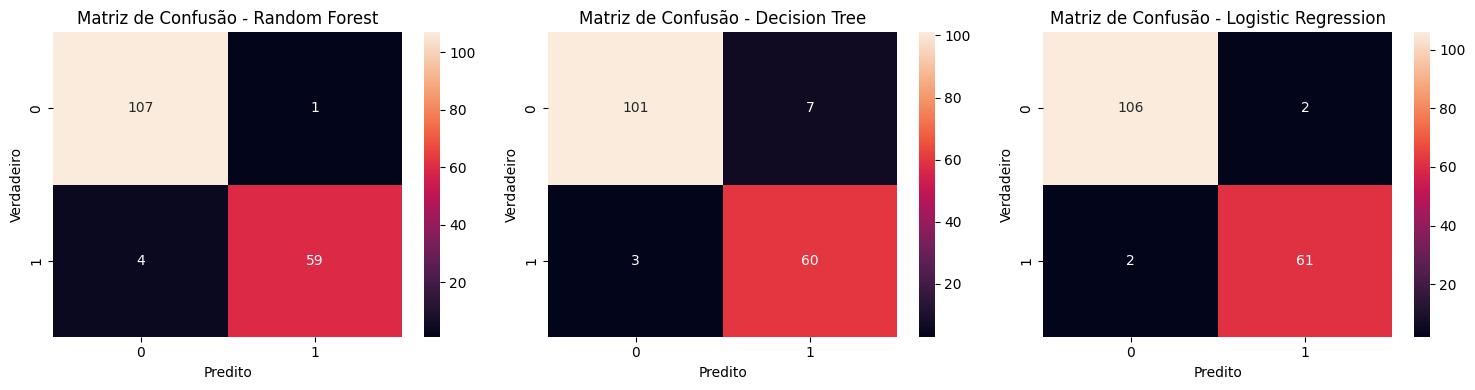

In [ ]:
# Define o número de modelos para determinar quantos subplots serão necessários
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(n_models * 5, 4))  # Ajuste o tamanho conforme necessário

if n_models == 1:
    axes = [axes]  # Garante que 'axes' seja iterável mesmo com um único modelo

# Iterando sobre cada modelo para plotar suas respectivas matrizes de confusão
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax)
    ax.set_title(f'Matriz de Confusão - {name}')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

## Comparativo de Desempenho via Curva ROC e AUC
Aqui, analisamos a Curva de Característica Operacional do Receptor (ROC) e a Área Sob a Curva (AUC) para cada modelo. Estes gráficos são cruciais para avaliar a capacidade dos modelos de discriminar entre as classes. Um valor de AUC mais alto indica um melhor desempenho do modelo na classificação das categorias.

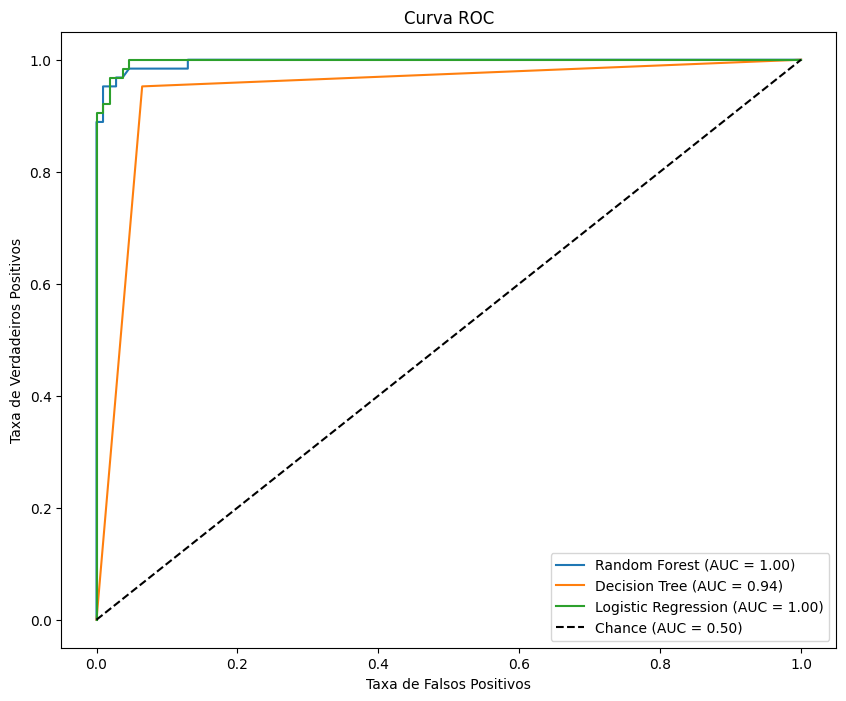

In [ ]:
# Plotando a curva ROC para cada modelo
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Avaliação de Overfitting Através de Validação Cruzada
Exploramos o potencial de overfitting dos modelos por meio de validação cruzada, utilizando diferentes partições dos dados. Esta análise ajuda a entender como os modelos se comportam em diferentes amostras dos dados, indicando sua capacidade de generalização e robustez.

In [ ]:
# Preparando uma lista para armazenar os resultados
results = []

# Avaliando o desempenho com validação cruzada para cada modelo
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5)
    results.append({
        'Modelo': name,
        'Scores de CV': cv_scores,
        'Média dos Scores': np.mean(cv_scores),
        'Desvio Padrão': np.std(cv_scores)
    })

# Criando um DataFrame para exibir os resultados
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Modelo')  # Definindo 'Modelo' como índice para melhor visualização
print(results_df)

                                                          Scores de CV  \
Modelo                                                                   
Random Forest        [0.9298245614035088, 0.9473684210526315, 0.973...   
Decision Tree        [0.9122807017543859, 0.9122807017543859, 0.929...   
Logistic Regression  [0.9385964912280702, 0.9473684210526315, 0.982...   

                     Média dos Scores  Desvio Padrão  
Modelo                                                
Random Forest                0.959587       0.018878  
Decision Tree                0.917358       0.015574  
Logistic Regression          0.950800       0.018041  
